In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as hg

import matplotlib.pyplot as plt

key = jr.key(137)

# Does order matter?

In [98]:
covariance = hg.test_cov_discretized(1e-3, 20, 10000, eps=1e-5)

In [99]:
n_points = 2048
n_initial = 16
key, k1 = jr.split(key)
xi = jr.normal(k1, shape=(n_points,))
points = jnp.linspace(0, 10, n_points)[:,None]

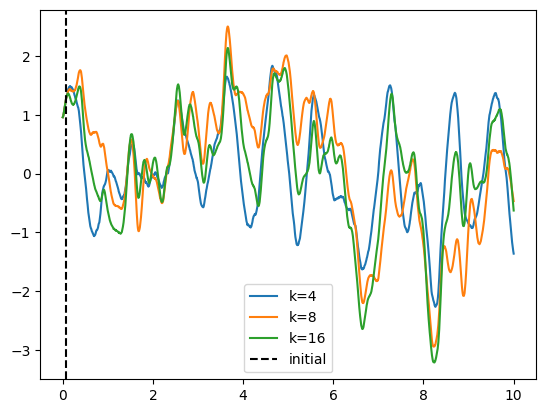

In [100]:
for k in [4, 8, 16]:
    neighbors = jnp.arange(n_points)[:,None] - jnp.arange(1,k+1)
    neighbors = jnp.asarray(neighbors, dtype=jnp.uint32)
    offsets = jnp.arange(n_initial, n_points)
    offsets = tuple(int(o) for o in offsets)
    values = hg.generate((points, neighbors, offsets), covariance, xi, cuda=True)
    plt.plot(points, values, label=f'k={k}')

plt.axvline(points[n_initial], color='k', linestyle='--', label='initial')
plt.legend()
plt.show()

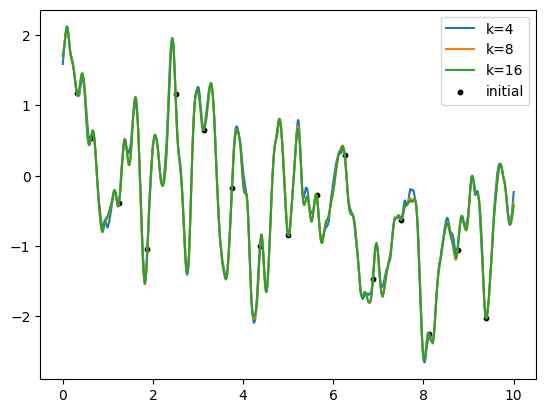

In [101]:
for k in [4, 8, 16]:
    graph, indices = hg.build_graph(points, n_initial=n_initial, k=k)
    values = hg.generate(graph, covariance, xi[jnp.argsort(indices)], cuda=True)
    plt.plot(points, values[indices], label=f'k={k}')

plt.scatter(points[jnp.argsort(indices)][:n_initial], values[:n_initial], color='k', label='initial', s=10)
plt.legend()
# plt.gca().set(xlim=(3,4))
plt.show()

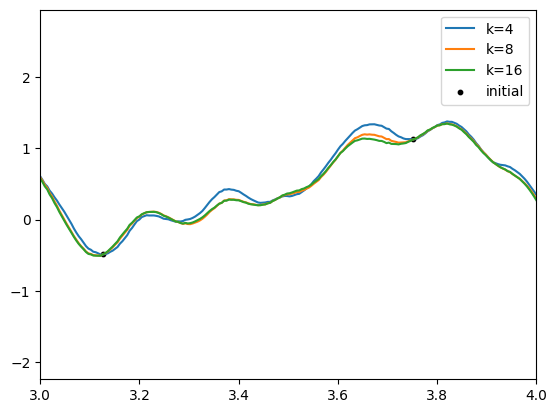

In [105]:
for k in [4, 8, 16]:
    graph, indices = hg.build_graph(points, n_initial=n_initial, k=k)
    values = hg.generate(graph, covariance, xi[jnp.argsort(indices)], cuda=True)
    plt.plot(points, values[indices], label=f'k={k}')

plt.scatter(points[jnp.argsort(indices)][:n_initial], values[:n_initial], color='k', label='initial', s=10)
plt.legend()
plt.gca().set(xlim=(3,4))
plt.show()

# Variance as a function of distance?

In [68]:
covariance = hg.test_cov_discretized(1e-3, 20, 10000, eps=1e-5)

In [69]:
n_points = 1_000
n_trials = 10_000
n_initial = 16

key, k1 = jr.split(key)
xi = jr.normal(k1, shape=(n_trials, n_points))
points = jnp.linspace(0, 10, n_points)[:,None]

In [ ]:
k_scan = [2, 4, 8, 16]
variance_scan = []

for k in k_scan:
    neighbors = jnp.arange(n_points)[:,None] - jnp.arange(1,k+1)
    neighbors = jnp.asarray(neighbors, dtype=jnp.uint32)
    offsets = jnp.arange(n_initial, n_points)
    offsets = tuple(int(o) for o in offsets)
    graph = (points, neighbors, offsets)
    values = jax.vmap(Partial(hg.generate, graph, covariance, cuda=True))(xi)[indices]
    cov = jnp.cov(values, rowvar=False)
    variance_scan.append(cov)

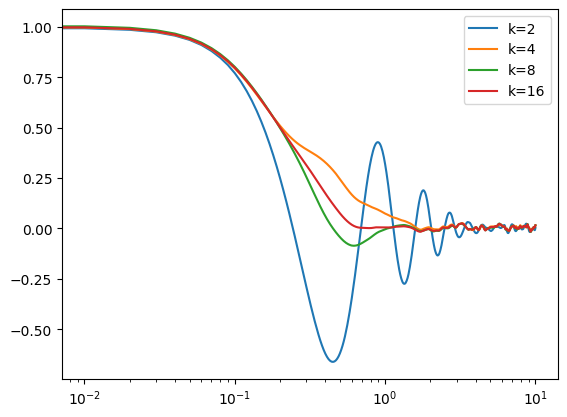

In [71]:
for i, k in enumerate(k_scan):
    plt.plot(10-points, variance_scan[i][-1], label=f'k={k}')

plt.xscale('log')
plt.legend()
plt.show()

In [81]:
k_scan = [2, 4, 8, 16]
variance_scan = []

for k in k_scan:
    graph, indices = hg.build_graph(points, n_initial=n_initial, k=k)
    values = jax.vmap(Partial(hg.generate, graph, covariance, cuda=True))(xi[jnp.argsort(indices)])[:,indices]
    cov = jnp.cov(values, rowvar=False)
    variance_scan.append(cov)

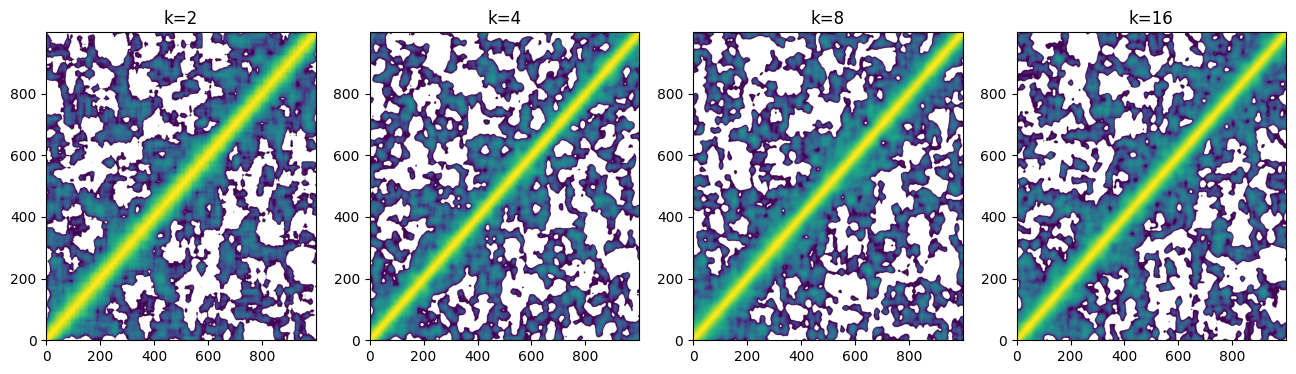

In [97]:
fig, axes = plt.subplots(1, len(k_scan), figsize=(4*len(k_scan), 4))
for i, k in enumerate(k_scan):
    axes[i].imshow(variance_scan[i], aspect='auto', origin='lower', norm='log', vmin=1e-2, vmax=1)
    axes[i].set_title(f'k={k}')
plt.show()

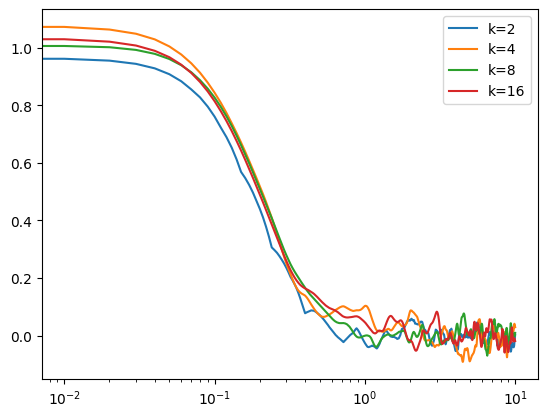

In [90]:
for i, k in enumerate(k_scan):
    plt.plot(10-points, variance_scan[i][-1], label=f'k={k}')

plt.xscale('log')
plt.legend()
plt.show()

# How does variance decay?

In [108]:
covariance = hg.test_cov_discretized(1e-3, 20, 10000, eps=1e-5)

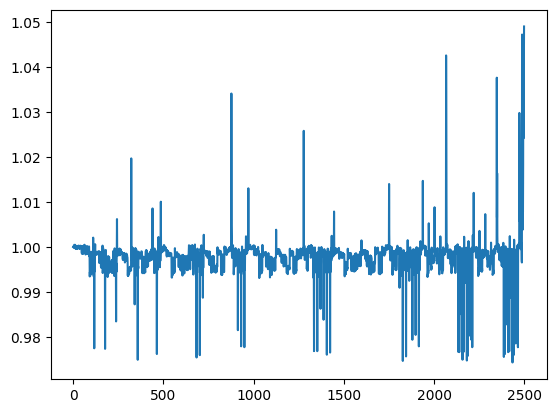

In [123]:
n_points = 2500
n_initial = 16
k = 4

points = jnp.linspace(0, 10, n_points)[:,None]
graph, indices = hg.build_graph(points, n_initial=n_initial, k=k)
# neighbors = jnp.arange(n_points)[:,None] - jnp.arange(1,k+1)
# neighbors = jnp.asarray(neighbors, dtype=jnp.uint32)
# offsets = jnp.arange(n_initial, n_points)
# offsets = tuple(int(o) for o in offsets)
# graph = (points, neighbors, offsets)

func = Partial(hg.generate, graph, covariance, cuda=True)
J = jax.jacfwd(func)(jnp.zeros(n_points))
variance = jnp.diagonal(J @ J.T)

plt.plot(variance)

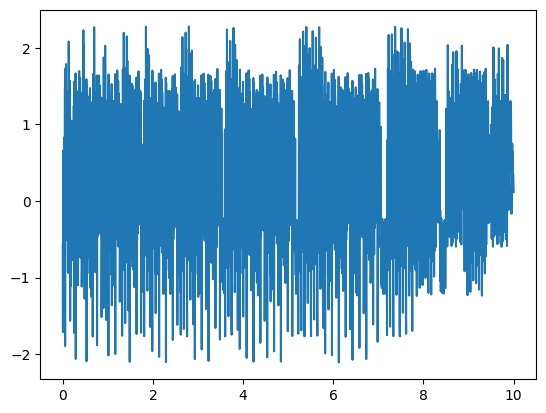

In [120]:
plt.plot(points, func(jr.normal(key, shape=(n_points,))), label='function')

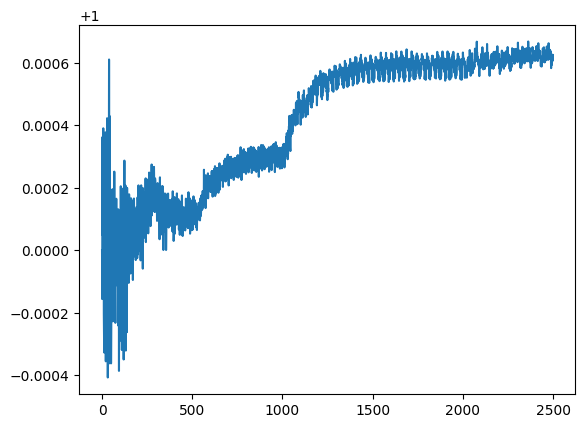

In [118]:
plt.plot(variance)

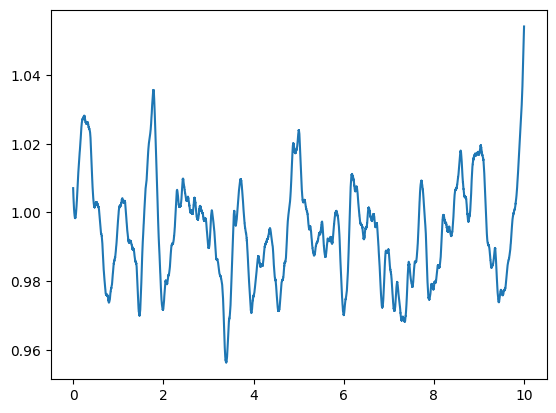

In [ ]:


key, k1 = jr.split(key)
xi = jr.normal(k1, shape=(n_trials, n_points))
points = jnp.linspace(0, 10, n_points)[:,None]
graph, indices = hg.build_graph(points, n_initial=n_initial, k=k)
values = jax.vmap(Partial(hg.generate, graph, covariance, cuda=True))(xi[:,jnp.argsort(indices)])
variance = jnp.var(values, axis=0)

# plt.scatter(jnp.arange(len(variance)), variance, s=0.1)
plt.plot(points, variance[indices])
plt.show()